# extract point data from gridded model fields

This notebook ...


# configure environment

In [1]:
work_dir       = './'
data_dir       = work_dir + 'DeepMIP-Eocene/User_Model_Database_v1.0/'

In [166]:
# load packages
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from netCDF4 import Dataset
from pathlib import Path
from matplotlib import gridspec
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# dictionaries containing info about DeepMIP models and variables
from deepmipModelDict import deepmipModelDict
from deepmipVariableDict import deepmipVariableDict

mpl.rcParams["figure.dpi"] = 300

# user input

In [111]:
modernLat = -42.17
modernLon = 145.33
siteName = 'Regatta Point'

In [171]:
userVariable  = 'near-surface air temperature'
varSelectDropdown = widgets.Dropdown(
    options=['near-surface air temperature', 'precipitation'],
    value='near-surface air temperature',
    description='Variable:',
    disabled=False,
)
def dropdown_handler(change):
    global userVariable
    userVariable = change.new 
varSelectDropdown.observe(dropdown_handler, names='value')
display(varSelectDropdown)

Dropdown(description='Variable:', options=('near-surface air temperature', 'precipitation'), value='near-surfa…

In [174]:
print(userVariable)

near-surface air temperature


## step 1: find paleoposition for DeepMIP model geography

In [4]:
# open Herold et al. (2014) rotation file
rotationFile = xr.open_dataset(work_dir + 'LatLon_PD_55Ma_Herold2014.nc') 
# look up modern coordinates in rotation file
paleoLat     = rotationFile.LAT.sel(latitude=modernLat, longitude=modernLon, method='nearest').values
paleoLon     = rotationFile.LON.sel(latitude=modernLat, longitude=modernLon, method='nearest').values

In [5]:
print('modern location: LAT: ' + str(modernLat) + ' / LON: ' + str(modernLon) )
print('paleo location: LAT: ' + str(paleoLat) + ' / LON: ' + str(paleoLon) )

modern location: LAT: -42.17 / LON: 145.33
paleo location: LAT: -63.85 / LON: 149.55


## step 2: load model data at paleoposition

In [6]:
# look up DeepMIP variable name
for variable in deepmipVariableDict.keys():
    if deepmipVariableDict[variable]['longname'] == userVariable:
        deepmipVariable = variable

# allocate empty list to store results for all models
siteDataList = []

expts = ['piControl', 'deepmip_sens_1xCO2', 'deepmip_sens_2xCO2', 'deepmip_stand_3xCO2', 'deepmip_sens_4xCO2', 'deepmip_stand_6xCO2', 'deepmip_sens_9xCO2']
exptLabels = ['piControl', 'DeepMIP_1x', 'DeepMIP_2x', 'DeepMIP_3x', 'DeepMIP_4x', 'DeepMIP_6x', 'DeepMIP_9x']

# loop over all models and experiments
for modelCount, model in enumerate(deepmipModelDict.keys()):
    for expCount, exp in enumerate(expts):
        
        # construct filename following the DeepMIP convention
        modelFile = data_dir + deepmipModelDict[model]['group'] + '/' + model + '/' + exp + '/' + deepmipModelDict[model]['versn'] + \
                    '/' + model + '-' + exp + '-' + deepmipVariable + '-' + deepmipModelDict[model]['versn'] + '.mean.nc'

        # load data if file for model/experiment combination exists
        if Path(modelFile).exists():
            modelDataset = xr.open_dataset(modelFile, decode_times=False)
            
            # get coordinate names
            for coord in modelDataset.coords:
                if coord in ['lat', 'latitude']:
                    latName = coord
                elif coord in ['lon', 'longitude']:
                    lonName = coord
                    
            if exp == 'piControl':
                lookupLat = modernLat
                lookupLon = modernLon
            else:
                lookupLat = paleoLat
                lookupLon = paleoLon              

            # check for minimum model longitude
            minModelLon = np.amin(modelDataset.coords[lonName].values)
            if minModelLon >= 0.0 and lookupLon < 0.0:
                # convert lookupLon from [-180:180] to [0:360]
                lookupLon = lookupLon + 360.0 
            
            varData = getattr(modelDataset, deepmipVariable)
            if deepmipVariable == 'tas':
                # convert from Kelvin to Celsius
                siteData = varData.sel(**{latName: lookupLat}, **{lonName: lookupLon}, method='nearest').values - 273.15
            elif deepmipVariable == 'pr':
                # convert from kg m-2 s-1 to mm/day
                siteData = varData.sel(**{latName: lookupLat}, **{lonName: lookupLon}, method='nearest').values * 86400.
            else:
                siteData = varData.sel(**{latName: lookupLat}, **{lonName: lookupLon}, method='nearest').values
            
            # store results for individual metrics in a list of dictionaries
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData), metric = 'annual mean' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.min(siteData), metric = 'monthly min' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.max(siteData), metric = 'monthly max' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData[[11,0,1]]), metric = 'DJF' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData[[2,3,4]]), metric = 'MAM' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData[[5,6,7]]), metric = 'JJA' ))
            siteDataList.append(dict(model = model, experiment = exptLabels[expCount], value = np.mean(siteData[[8,9,10]]), metric = 'SON' ))

# convert dictionaries to Pandas dataframe after the loops for easier plotting  
df = pd.DataFrame(siteDataList)

## step 3: plot results

### 3.1 paleogeography with rotated site

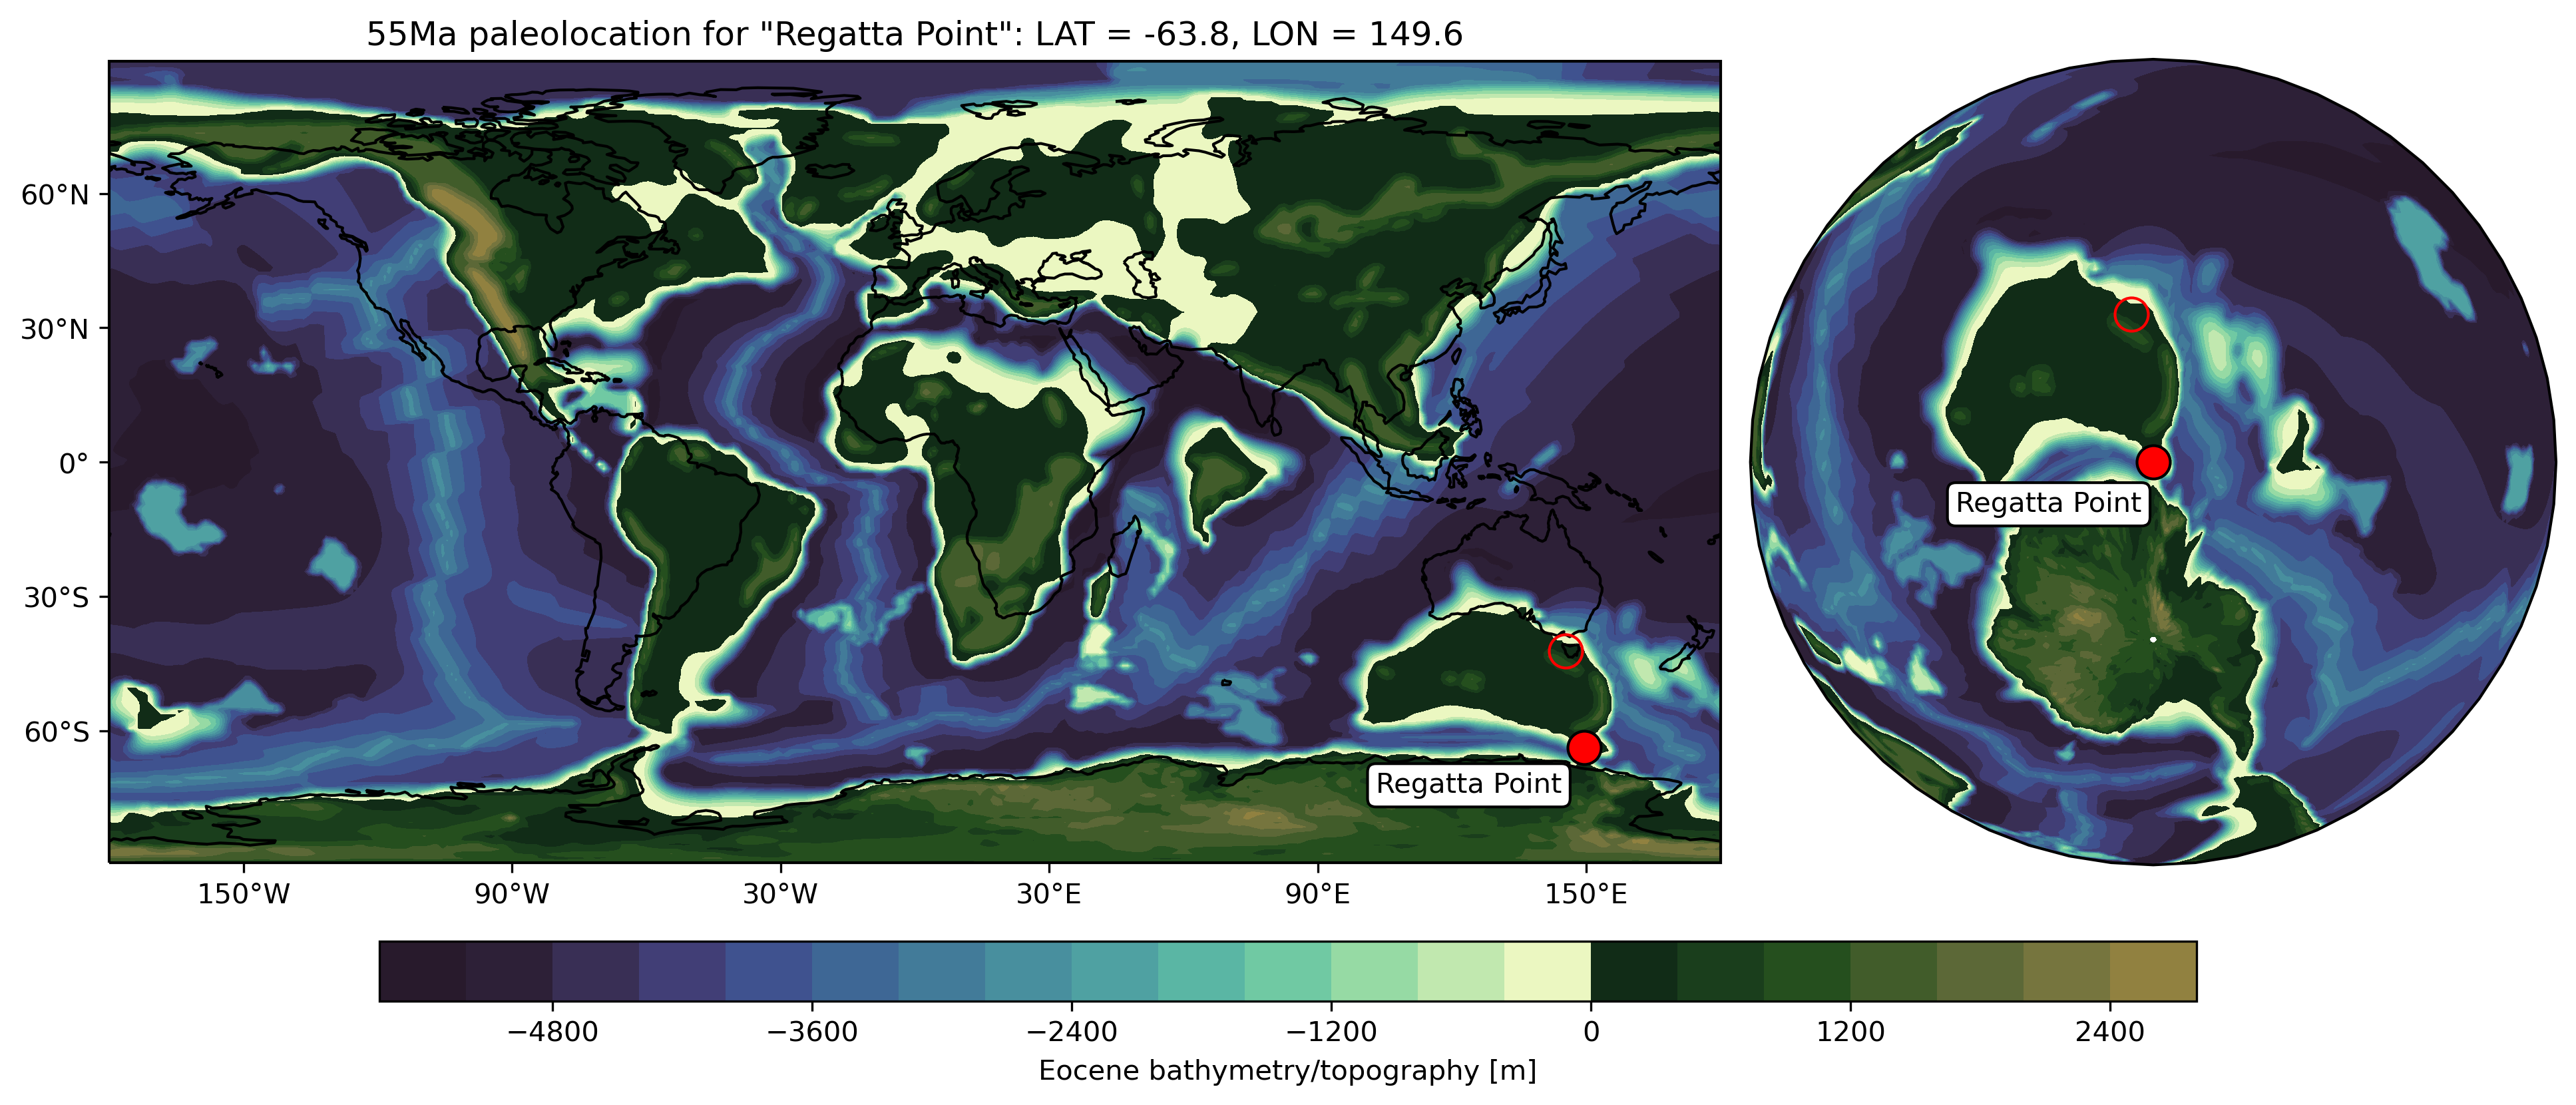

In [137]:
# open Herold et al. (2014) paleogeography
geography = xr.open_dataset(work_dir + 'herold_etal_eocene_topo_1x1.nc').topo
lons = xr.open_dataset(work_dir + 'herold_etal_eocene_topo_1x1.nc').lon
lats = xr.open_dataset(work_dir + 'herold_etal_eocene_topo_1x1.nc').lat

# add cyclic longitude for plotting
geography, lonsc = add_cyclic_point(geography, lons)

# define figure layout
fig1 = plt.figure(figsize=(13, 6))

# global map twice as wide as orthographic map
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

# plot global map
ax1 = plt.subplot(gs[0], projection=ccrs.PlateCarree())
cf1 = ax1.contourf(lonsc, lats, geography, cmap='cmo.topo', levels=20, vmin=-5200, vmax=5200, transform=ccrs.PlateCarree())

# add modern coastlines for comparison
ax1.coastlines()

# add axis tick labels
ax1.set_xticks([-150, -90, -30, 30, 90, 150], crs=ccrs.PlateCarree())
ax1.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set(title = '55Ma paleolocation for "' + siteName + '": LAT = ' + str(np.round(paleoLat, 1)) + ', LON = ' + str(np.round(paleoLon, 1)) , xlabel='', ylabel='')

# plot orthographic ma with site in center
ax2 = plt.subplot(gs[1], projection=ccrs.Orthographic(paleoLon, paleoLat))
ax2.contourf(lonsc, lats, geography, cmap='cmo.topo', levels=20, vmin=-5200, vmax=5200, transform=ccrs.PlateCarree())
ax.coastlines()

# add site marker at paleolocation
ax1.plot(modernLon, modernLat, 'ro', markersize=12, markerfacecolor='none', markeredgecolor='r', transform=ccrs.PlateCarree())
ax2.plot(modernLon, modernLat, 'ro', markersize=12, markerfacecolor='none', markeredgecolor='r', transform=ccrs.PlateCarree())
ax1.plot(paleoLon, paleoLat, 'ro', markersize=12, markeredgecolor='black', transform=ccrs.PlateCarree())
ax2.plot(paleoLon, paleoLat, 'ro', markersize=12, markeredgecolor='black', transform=ccrs.PlateCarree())
ax1.text(paleoLon-5, paleoLat-10, siteName, horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round') , transform=ccrs.PlateCarree())
ax2.text(paleoLon-5, paleoLat-7, siteName, horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round') , transform=ccrs.PlateCarree())

# add common colorbar
cbar_ax = fig1.add_axes([0.15, 0.05, 0.7, 0.05])
cb = plt.colorbar(cf1, cax=cbar_ax, orientation='horizontal', extend='both')
cb.set_label('Eocene bathymetry/topography [m]')
plt.tight_layout()

### 3.2 boxplots of model data at paleolocation

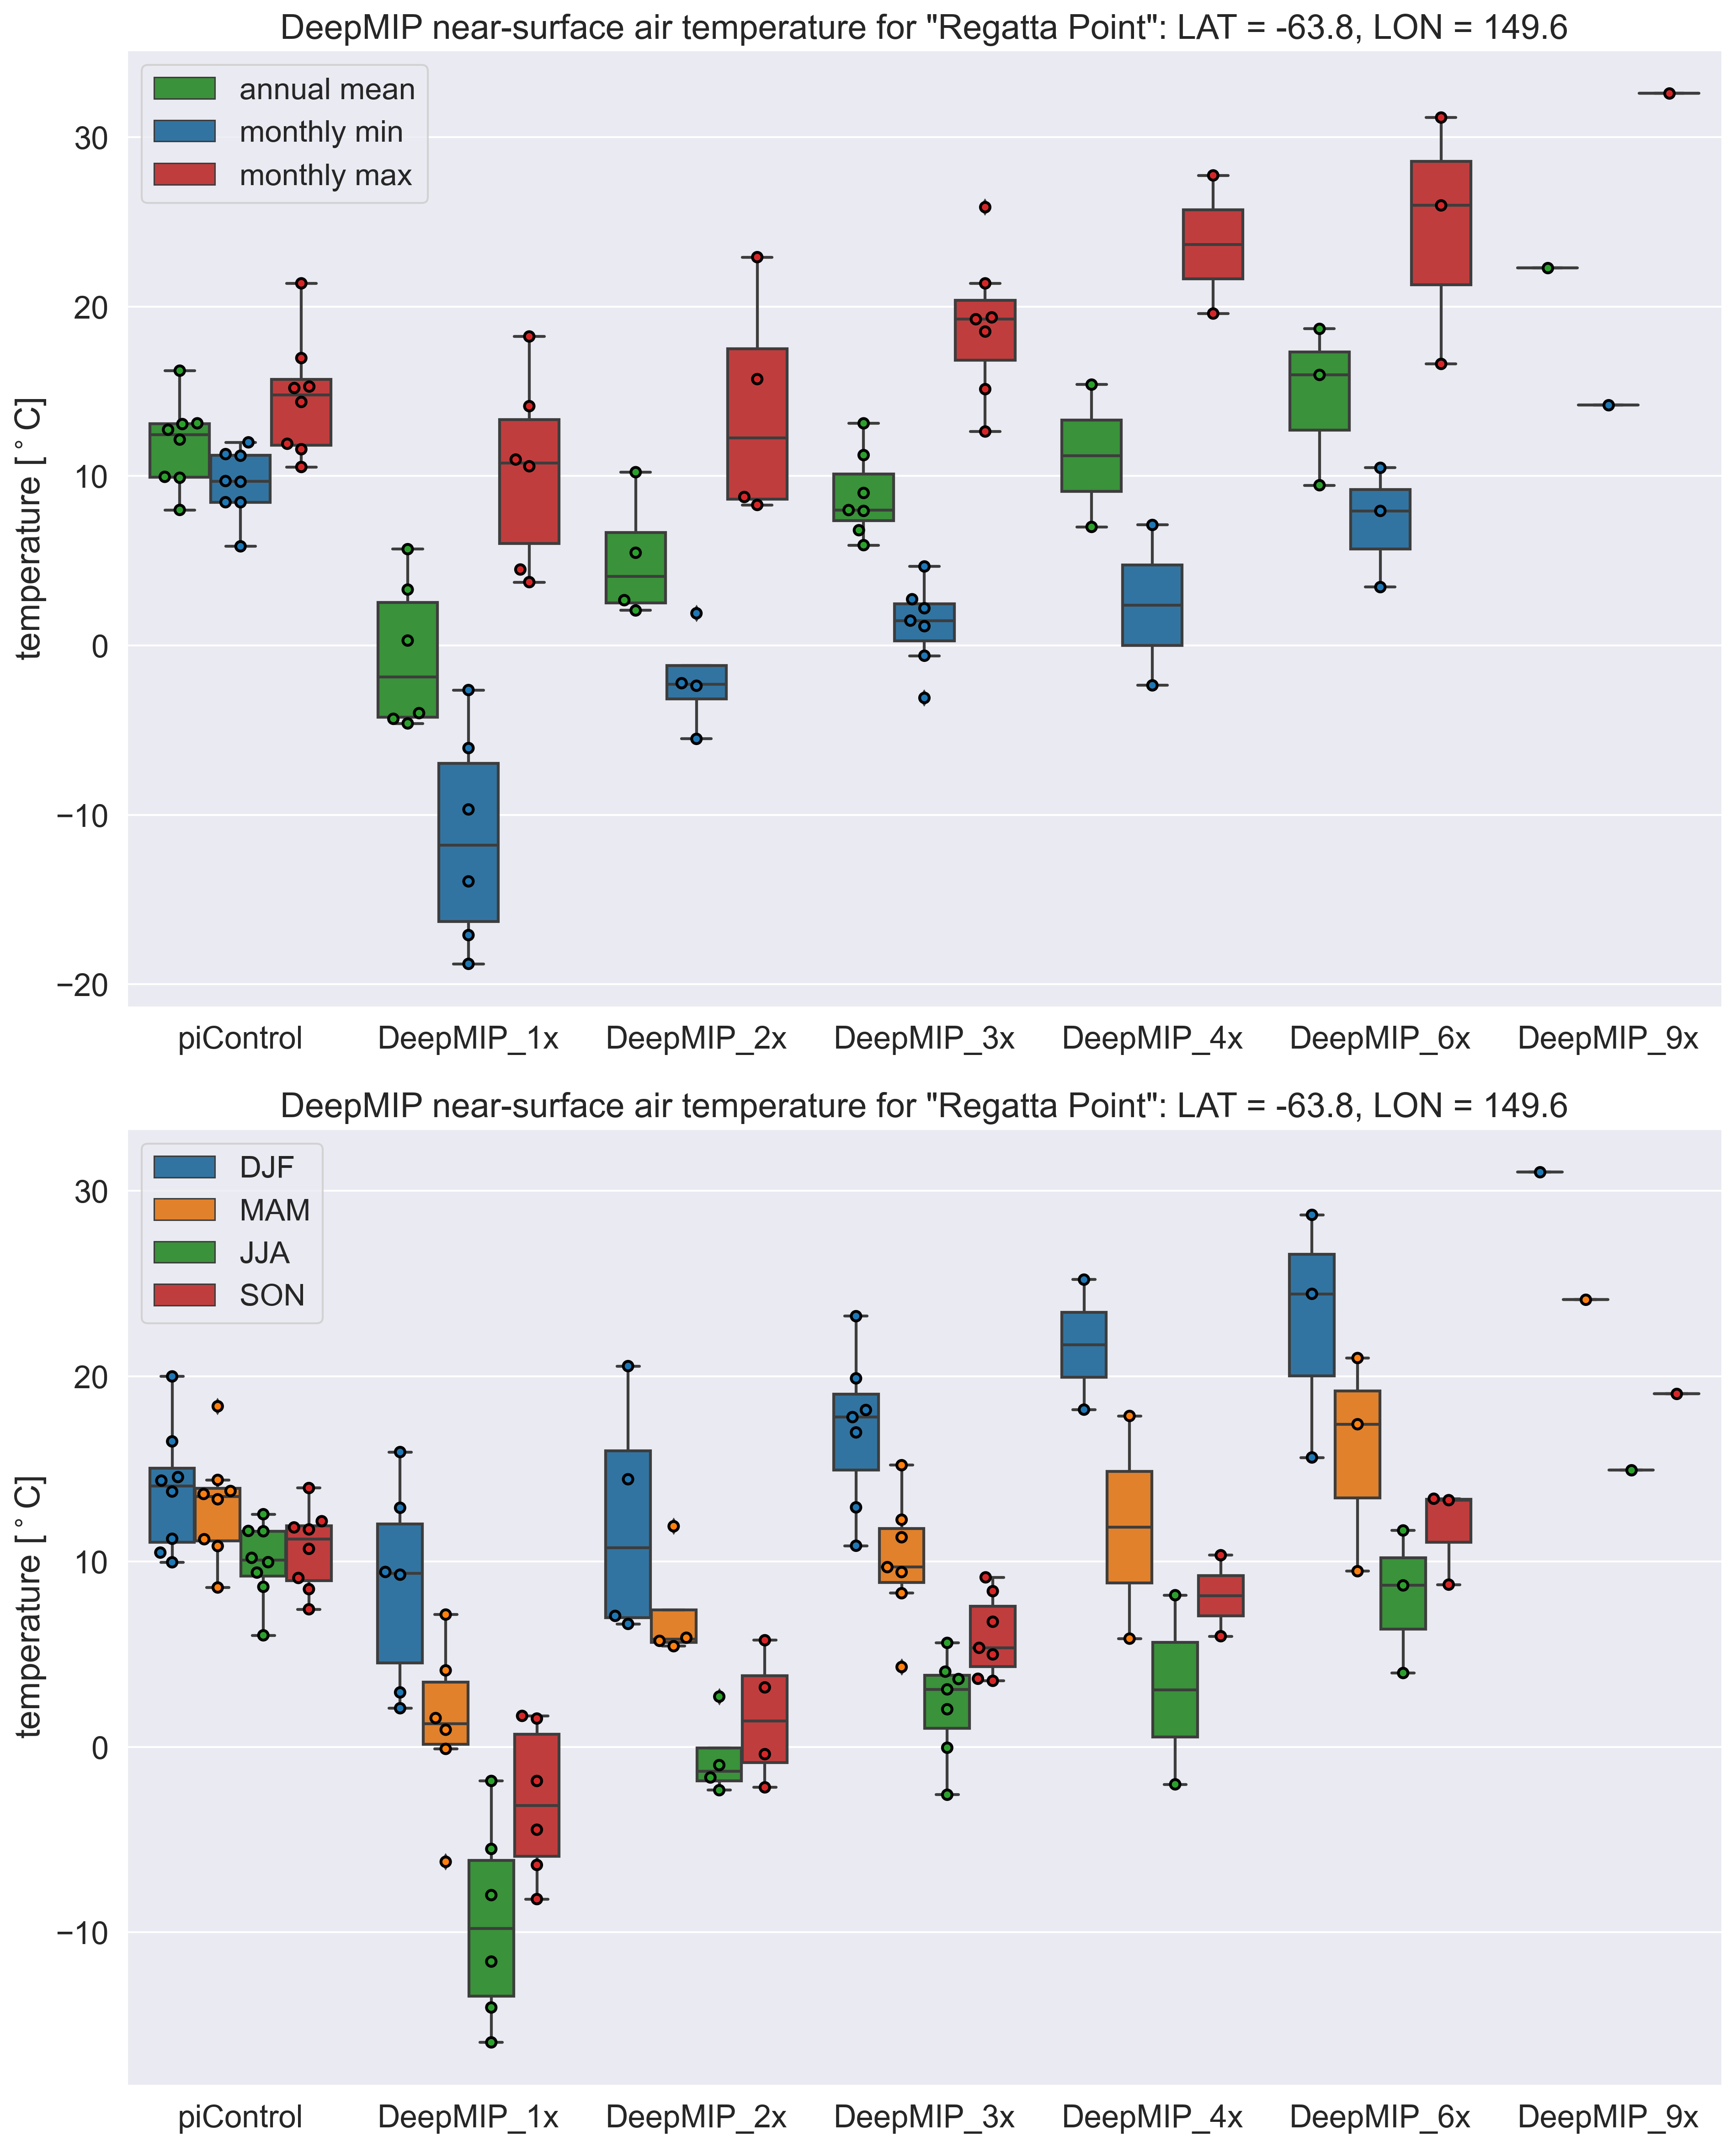

In [165]:
# define figure layout first
fig2, axes = plt.subplots(2, 1, figsize=(13, 16))

# boxplot with seaborn (https://seaborn.pydata.org/generated/seaborn.boxplot.html)
#sns.set(font_scale = 1)
#sns.set_theme()
sns.set_context("notebook", font_scale=1.5)

ax3 = sns.boxplot(data=df, x="experiment", y="value", hue='metric', hue_order=['annual mean', 'monthly min', 'monthly max'], order=exptLabels, palette = ['tab:green','tab:blue','tab:red'], ax=axes[0])
ax3 = sns.swarmplot(data=df, x="experiment", y="value", hue='metric', hue_order=['annual mean', 'monthly min', 'monthly max'], order=exptLabels, palette = ['tab:green','tab:blue','tab:red'], linewidth=1.5, edgecolor='black', size=5, dodge=True, ax=axes[0])

ax4 = sns.boxplot(data=df, x="experiment", y="value", hue='metric', hue_order=['DJF', 'MAM', 'JJA', 'SON'], order=exptLabels, palette = ['tab:blue', 'tab:orange', 'tab:green','tab:red'], ax=axes[1])
ax4 = sns.swarmplot(data=df, x="experiment", y="value", hue='metric', hue_order=['DJF', 'MAM', 'JJA', 'SON'], order=exptLabels, palette = ['tab:blue', 'tab:orange', 'tab:green','tab:red'], linewidth=1.5, edgecolor='black', size=5, dodge=True, ax=axes[1])

# modify legends and axes
title = deepmipVariableDict[deepmipVariable]['longname']
yLabel = deepmipVariableDict[deepmipVariable]['label']

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles[0:3], labels[0:3], fontsize='16');
ax3.set(title = 'DeepMIP ' + title + ' for "' + siteName + '": LAT = ' + str(np.round(paleoLat, 1)) + ', LON = ' + str(np.round(paleoLon, 1)), xlabel='', ylabel=yLabel);

handles2, labels2 = ax4.get_legend_handles_labels()
ax4.legend(handles2[0:4], labels2[0:4], fontsize='16');
ax4.set(title = 'DeepMIP ' + title + ' for "' + siteName + '": LAT = ' + str(np.round(paleoLat, 1)) + ', LON = ' + str(np.round(paleoLon, 1)), xlabel='', ylabel=yLabel);

plt.tight_layout()